In [1]:
import numpy as np
from os import path
import matplotlib.pyplot as plt
from scipy.stats import entropy
from os import listdir
import pandas as pd
from sklearn.metrics import RocCurveDisplay,roc_curve,DetCurveDisplay

array([[<AxesSubplot:title={'center':'quantile_max_fixations'}>]],
      dtype=object)

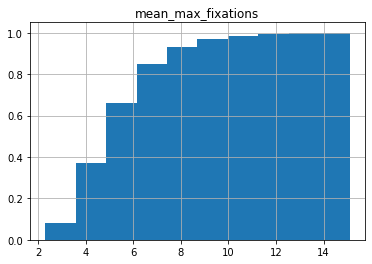

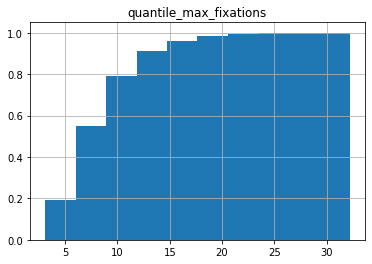

In [19]:

from torch import cumulative_trapezoid


tp_data = np.load(path.abspath("target_present_data.npz"))
#obtengo los índices de fin de scanpath
sequence_start = np.where(tp_data["fixations"] == 1)[0]
sequence_end = np.append(sequence_start[1:]-1,[tp_data["fixations"].shape[0]-1])

tp_df= pd.DataFrame.from_dict({item: tp_data[item] for item in tp_data.files if item !='posteriors'}).astype(np.int64).iloc[sequence_end]

ta_data = np.load(path.abspath("target_absent_data.npz"))
#obtengo los índices de fin de scanpath
sequence_start = np.where(ta_data["fixations"] == 1)[0]
sequence_end = np.append(sequence_start[1:]-1,[ta_data["fixations"].shape[0]-1])


ta_df= pd.DataFrame.from_dict({item: ta_data[item] for item in ta_data.files if item !='posteriors'}).astype(np.int64).iloc[sequence_end]

full_data = pd.concat([ta_df,tp_df],axis=0,ignore_index=True)

mean_fixations_by_image = ta_df[["image_ids","fixations"]].groupby(["image_ids"]).mean()
mean_fixations_by_image.columns = ["mean_max_fixations"]
mean_fixations_by_image.reset_index()

quantile_fixations_by_image = ta_df[["image_ids","fixations"]].groupby(["image_ids"]).quantile(0.9)
quantile_fixations_by_image.columns = ["quantile_max_fixations"]
quantile_fixations_by_image.reset_index()


mean_fixations_by_image.hist(cumulative=True,density=True)
quantile_fixations_by_image.hist(cumulative=True,density=True)


Text(0, 0.5, 'True Negative Rate')

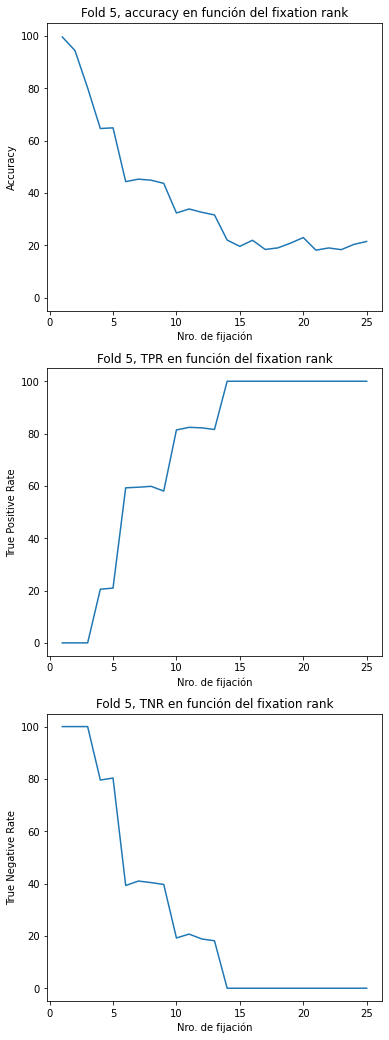

In [38]:
#Baseline Model

fixations = np.concatenate((ta_data["fixations"],tp_data["fixations"]))
predictions = np.empty(shape=0,dtype=np.int32)
for fixation in fixations:
    if fixation <4:
        proba=0.0
    elif 4 <= fixation <=5:
        proba = 0.2
    elif 6 <= fixation <= 9:
        proba = 0.6
    elif 10 <= fixation <= 13:
        proba = 0.8
    else:
        proba = 1.0
    predictions = np.append(predictions,np.random.binomial(1,proba))
fig, ax = plt.subplots(3, 1, figsize = (6,18),sharey=True)


labels = np.concatenate((ta_data["labels"],tp_data["labels"]))
indexes_by_fix_number = []
acc_by_fix = np.empty(shape=(0,))
tpr_by_fix = np.empty(shape=(0,))
tnr_by_fix = np.empty(shape=(0,))

for j in range(1,26):
    indexes_by_fix_number.append(np.where(fixations == j)[0])
for array in indexes_by_fix_number:
    labels_by_fix = labels[array]
    positives = np.sum(labels_by_fix == 1)
    negatives = np.sum(labels_by_fix == 0)
    predictions_by_fix = predictions[array]
    true_positives = np.sum(np.logical_and(predictions_by_fix,labels_by_fix))
    true_negatives = np.sum(np.logical_not(np.logical_or(predictions_by_fix,labels_by_fix)))
    total = positives + negatives
    correct = true_positives + true_negatives
    
    tpr_by_fix = np.append(tpr_by_fix,100.0 * true_positives / positives)
    tnr_by_fix = np.append(tnr_by_fix,100.0 * true_negatives / negatives)
    acc_by_fix = np.append(acc_by_fix,100.0 * correct / total)
  
ax[0].plot(range(1,26),acc_by_fix)
ax[0].set_title(f"Fold {i}, accuracy en función del fixation rank")
ax[0].set_xlabel("Nro. de fijación")
ax[0].set_ylabel("Accuracy")
ax[1].plot(range(1,26),tpr_by_fix)
ax[1].set_title(f"Fold {i}, TPR en función del fixation rank")
ax[1].set_xlabel("Nro. de fijación")
ax[1].set_ylabel("True Positive Rate")
ax[2].plot(range(1,26),tnr_by_fix)
ax[2].set_title(f"Fold {i}, TNR en función del fixation rank")
ax[2].set_xlabel("Nro. de fijación")
ax[2].set_ylabel("True Negative Rate")


In [11]:
positives = 0
negatives = 0
for i in range(1,6):
    dict = np.load(path.abspath(f"gng-outputs-{i}.npz"))
    outputs = dict["outputs"][1:]
    labels = dict["labels"][1:]
    fixations = dict["fixations"][1:]
    continue_labels_indexes = np.where(labels == 0)[0]
    stop_labels_indexes = np.where(labels == 1)[0]
    negatives += len(continue_labels_indexes)
    positives += len(stop_labels_indexes)
total= positives+negatives
print(total)

print(100.0*positives/total)
print(100.0*negatives/total)






182168
13.661016204821923
86.33898379517808


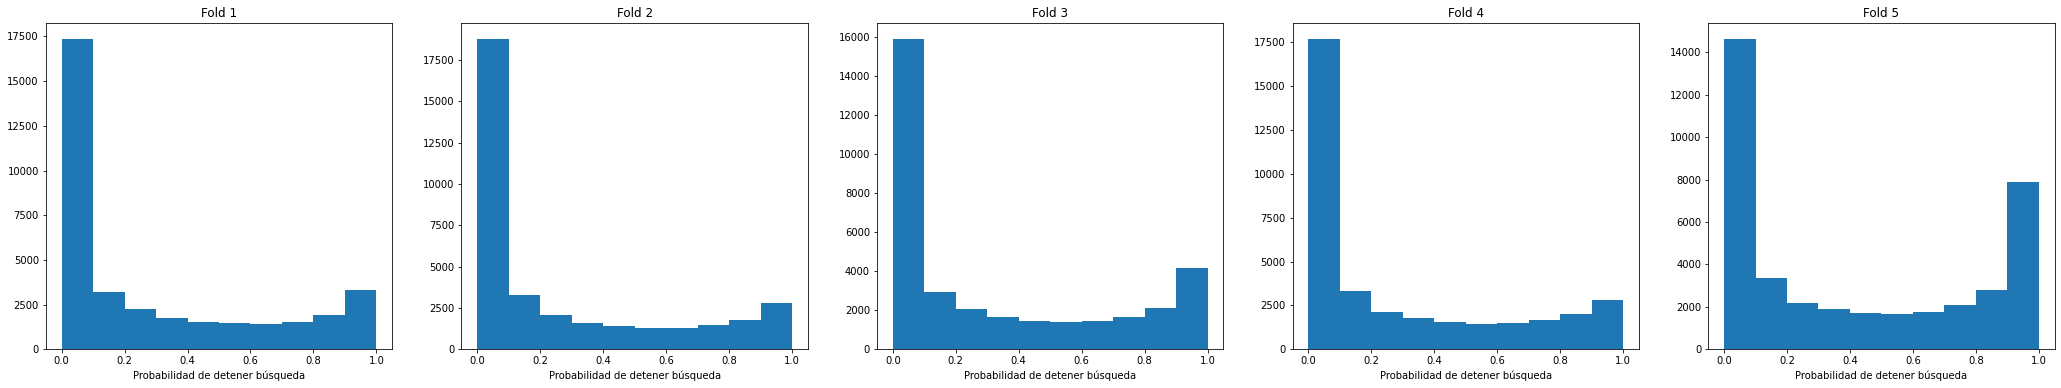

In [31]:
#distribuciones generales
#BORRAR LOS [1:] AL TENER LOS NUEVOS RESULTADOS
#BORRAR LOS [1:] AL TENER LOS NUEVOS RESULTADOS
#BORRAR LOS [1:] AL TENER LOS NUEVOS RESULTADOS
#BORRAR LOS [1:] AL TENER LOS NUEVOS RESULTADOS
#BORRAR LOS [1:] AL TENER LOS NUEVOS RESULTADOS
#BORRAR LOS [1:] AL TENER LOS NUEVOS RESULTADOS
fig, ax = plt.subplots(1, 5, figsize = (36,6))
for i in range(1,6):
    outputs = np.load(path.abspath(f"gng-outputs-{i}.npz"))["outputs"][1:]

    ax[i-1].hist(outputs)
    ax[i-1].set_title(f"Fold {i}")
    ax[i-1].set_xlabel("Probabilidad de detener búsqueda")
    


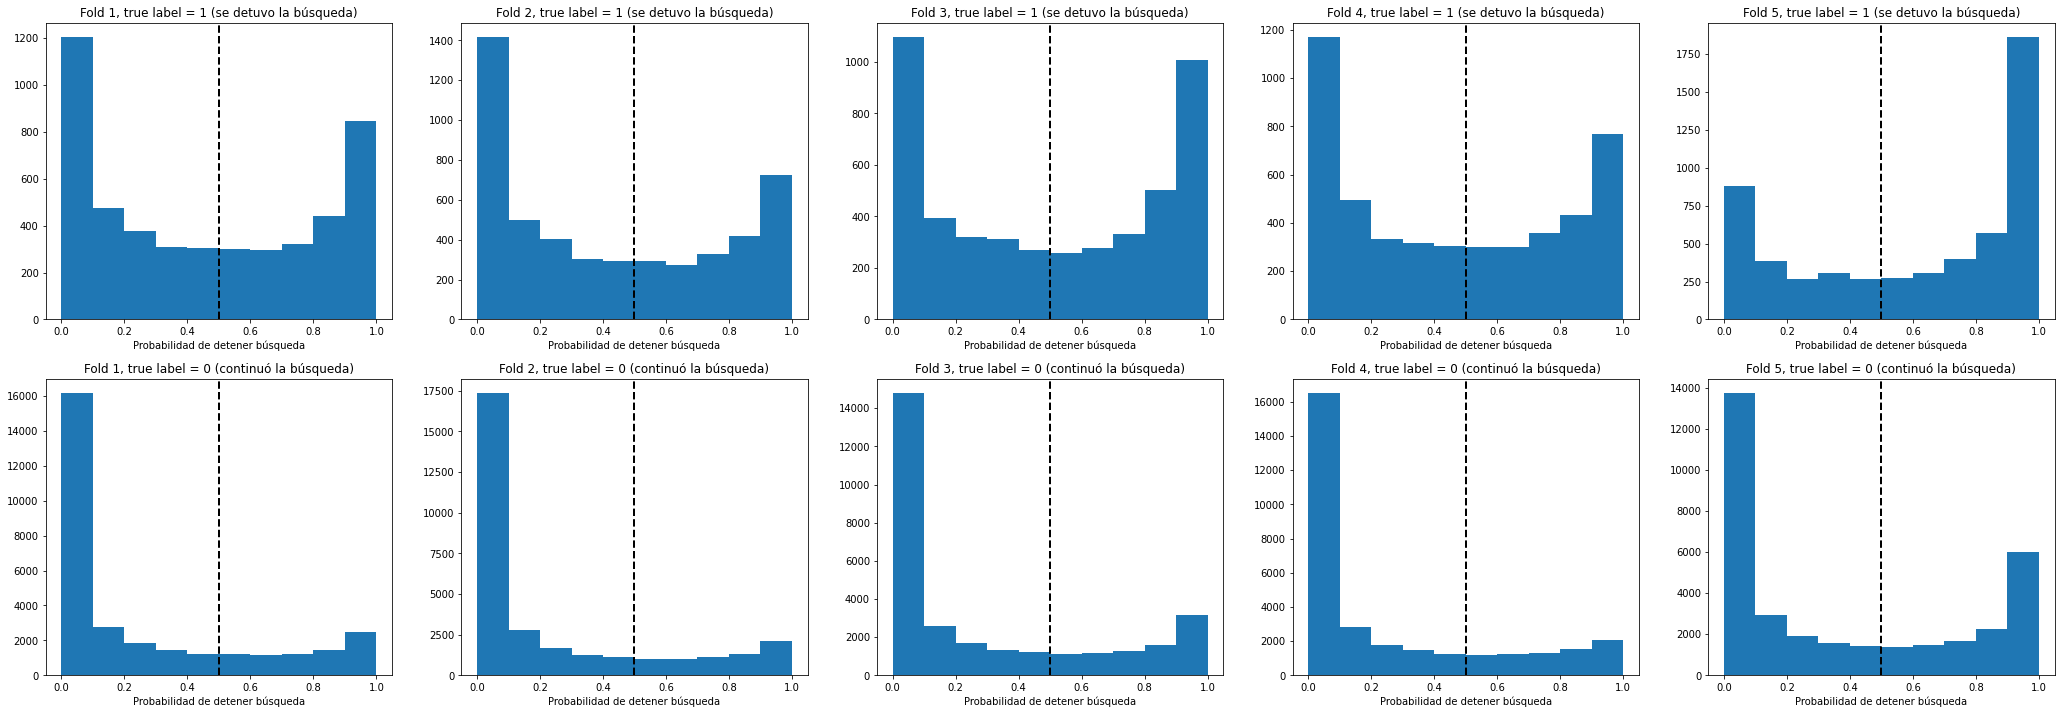

In [13]:
#distribuciones por label
fig, ax = plt.subplots(2, 5, figsize = (36,12))
for i in range(1,6):
    dict = np.load(path.abspath(f"gng-outputs-{i}.npz"))
    outputs = dict["outputs"][1:]
    labels = dict["labels"][1:]

    continue_labels_indexes = np.where(labels == 0)[0]
    stop_labels_indexes = np.where(labels == 1)[0]
    stop_outputs = outputs[stop_labels_indexes]
    continue_outputs = outputs[continue_labels_indexes]
    ax[0][i-1].hist(stop_outputs)
    ax[0][i-1].set_title(f"Fold {i}, true label = 1 (se detuvo la búsqueda)")
    ax[0][i-1].set_xlabel("Probabilidad de detener búsqueda")
    ax[1][i-1].hist(continue_outputs)
    ax[1][i-1].set_title(f"Fold {i}, true label = 0 (continuó la búsqueda)")
    ax[1][i-1].set_xlabel("Probabilidad de detener búsqueda")
    ax[1][i-1].axvline(x=[0.5], color='black', ls='--', lw=2, label='umbral de decisión')
    ax[0][i-1].axvline(x=[0.5], color='black', ls='--', lw=2, label='umbral de decisión')


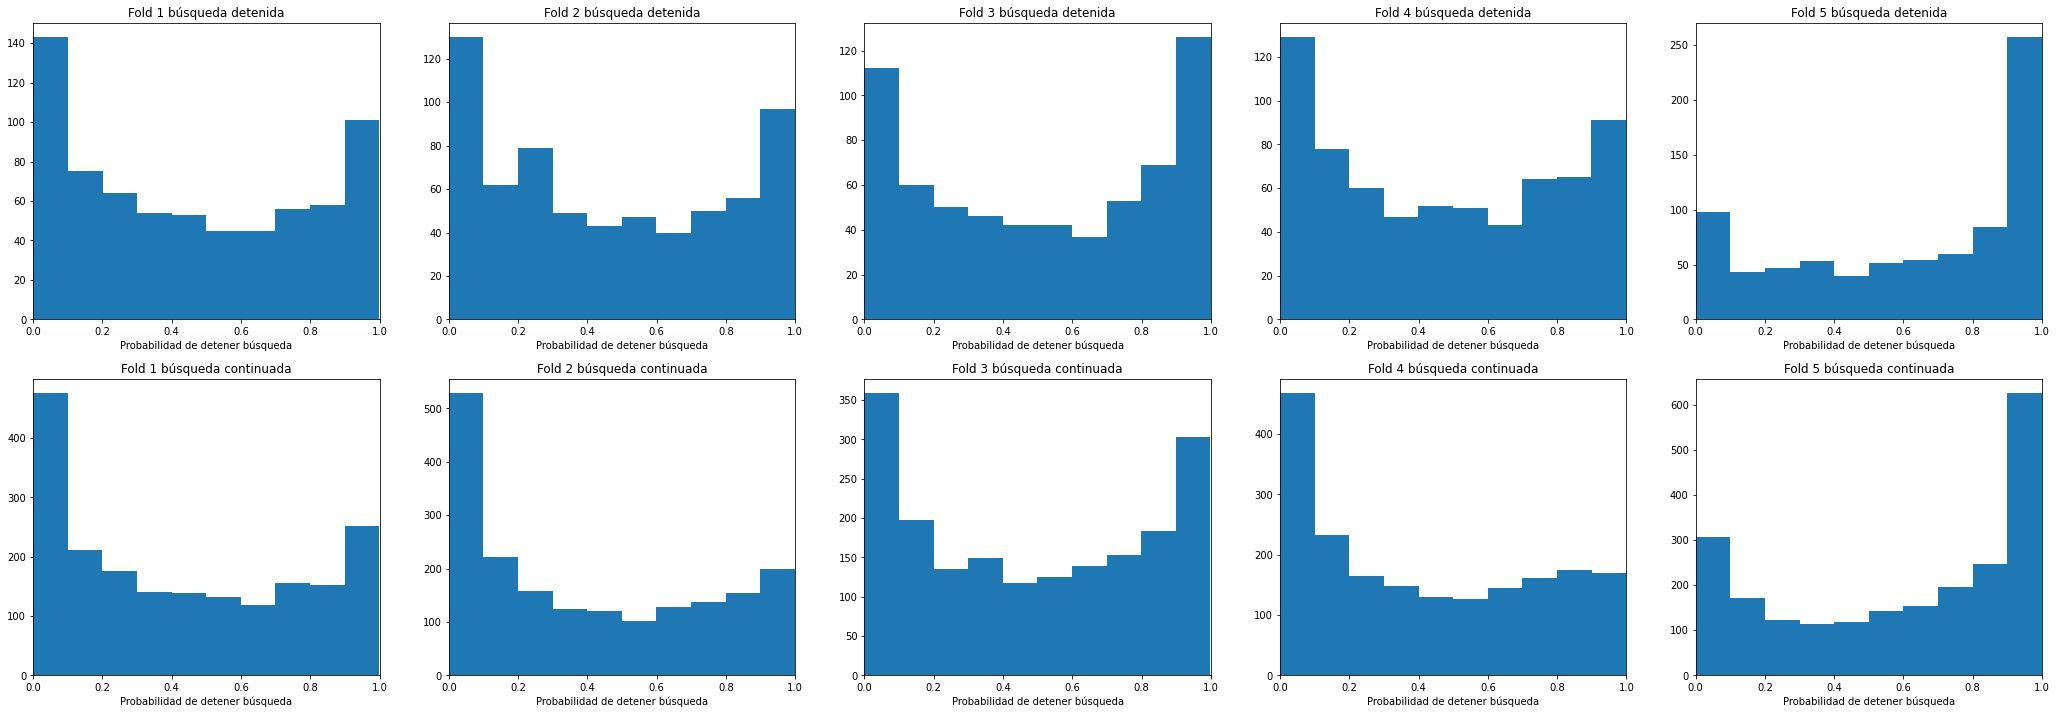

In [14]:
#distribuciones por número de fijación
fig, ax = plt.subplots(2, 5, figsize = (36,12))
for i in range(1,6):
    dict = np.load(path.abspath(f"gng-outputs-{i}.npz"))
    outputs = dict["outputs"][1:]
    labels = dict["labels"][1:]
    fixations = dict["fixations"][1:]

    fixation_indexes = np.where(fixations == 5)[0]     
    continue_labels_indexes = np.where(labels == 0)[0]
    stop_labels_indexes = np.where(labels == 1)[0]
    continue_labels_indexes = np.intersect1d(continue_labels_indexes,fixation_indexes)
    stop_labels_indexes = np.intersect1d(stop_labels_indexes,fixation_indexes)    
    stop_outputs = outputs[stop_labels_indexes]
    continue_outputs = outputs[continue_labels_indexes]    
    ax[0][i-1].hist(stop_outputs)
    ax[0][i-1].set_title(f"Fold {i}, true label = 1 (se detuvo la búsqueda)")
    ax[0][i-1].set_xlabel("Probabilidad de detener búsqueda")
    ax[0][i-1].set_xlim(0,1)
    ax[1][i-1].hist(continue_outputs)
    ax[1][i-1].set_xlim(0,1)
    ax[1][i-1].set_title(f"Fold {i}, true label = 0 (continuó la búsqueda)")
    ax[1][i-1].set_xlabel("Probabilidad de detener búsqueda")

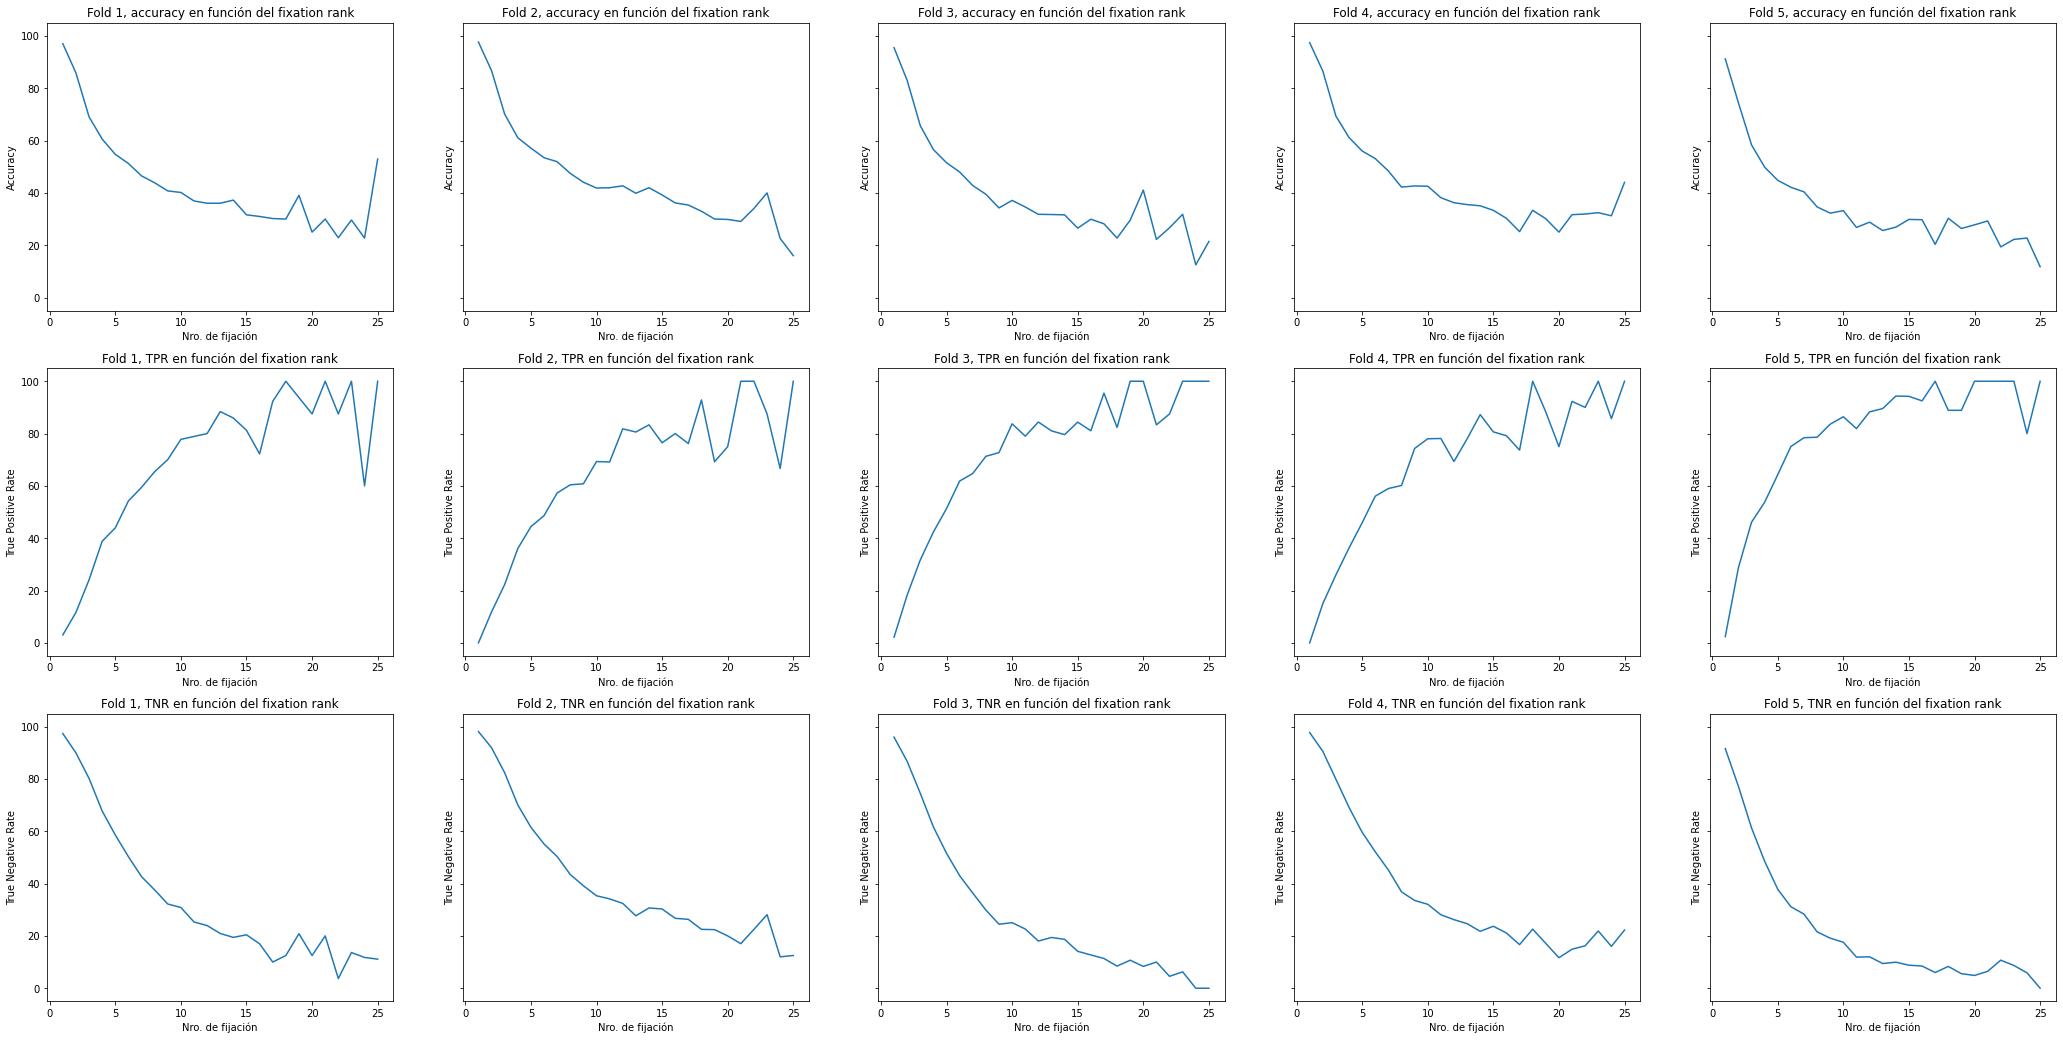

In [35]:
#distribuciones por número de fijación



fig, ax = plt.subplots(3, 5, figsize = (36,18),sharey=True)
for i in range(1,6):
    dict = np.load(path.abspath(f"gng-outputs-{i}.npz"))
    outputs = dict["outputs"][1:]
    labels = dict["labels"][1:]
    fixations = dict["fixations"][1:]
    fixations = np.array(fixations,dtype=np.int32)
    indexes_by_fix_number = []
    acc_by_fix = np.empty(shape=(0,))
    tpr_by_fix = np.empty(shape=(0,))
    tnr_by_fix = np.empty(shape=(0,))

    for j in range(1,26):
        indexes_by_fix_number.append(np.where(fixations == j)[0])
    for array in indexes_by_fix_number:
        outputs_by_fix = outputs[array]
        labels_by_fix = labels[array]
        positives = np.sum(labels_by_fix == 1)
        negatives = np.sum(labels_by_fix == 0)
        predictions_by_fix = outputs_by_fix >= 0.5
        true_positives = np.sum(np.logical_and(predictions_by_fix,labels_by_fix))
        true_negatives = np.sum(np.logical_not(np.logical_or(predictions_by_fix,labels_by_fix)))
        total = positives + negatives
        correct = true_positives + true_negatives
        
        tpr_by_fix = np.append(tpr_by_fix,100.0 * true_positives / positives)
        tnr_by_fix = np.append(tnr_by_fix,100.0 * true_negatives / negatives)
        acc_by_fix = np.append(acc_by_fix,100.0 * correct / total)
 
    ax[0][i-1].plot(range(1,26),acc_by_fix)
    ax[0][i-1].set_title(f"Fold {i}, accuracy en función del fixation rank")
    ax[0][i-1].set_xlabel("Nro. de fijación")
    ax[0][i-1].set_ylabel("Accuracy")
    ax[1][i-1].plot(range(1,26),tpr_by_fix)
    ax[1][i-1].set_title(f"Fold {i}, TPR en función del fixation rank")
    ax[1][i-1].set_xlabel("Nro. de fijación")
    ax[1][i-1].set_ylabel("True Positive Rate")
    ax[2][i-1].plot(range(1,26),tnr_by_fix)
    ax[2][i-1].set_title(f"Fold {i}, TNR en función del fixation rank")
    ax[2][i-1].set_xlabel("Nro. de fijación")
    ax[2][i-1].set_ylabel("True Negative Rate")



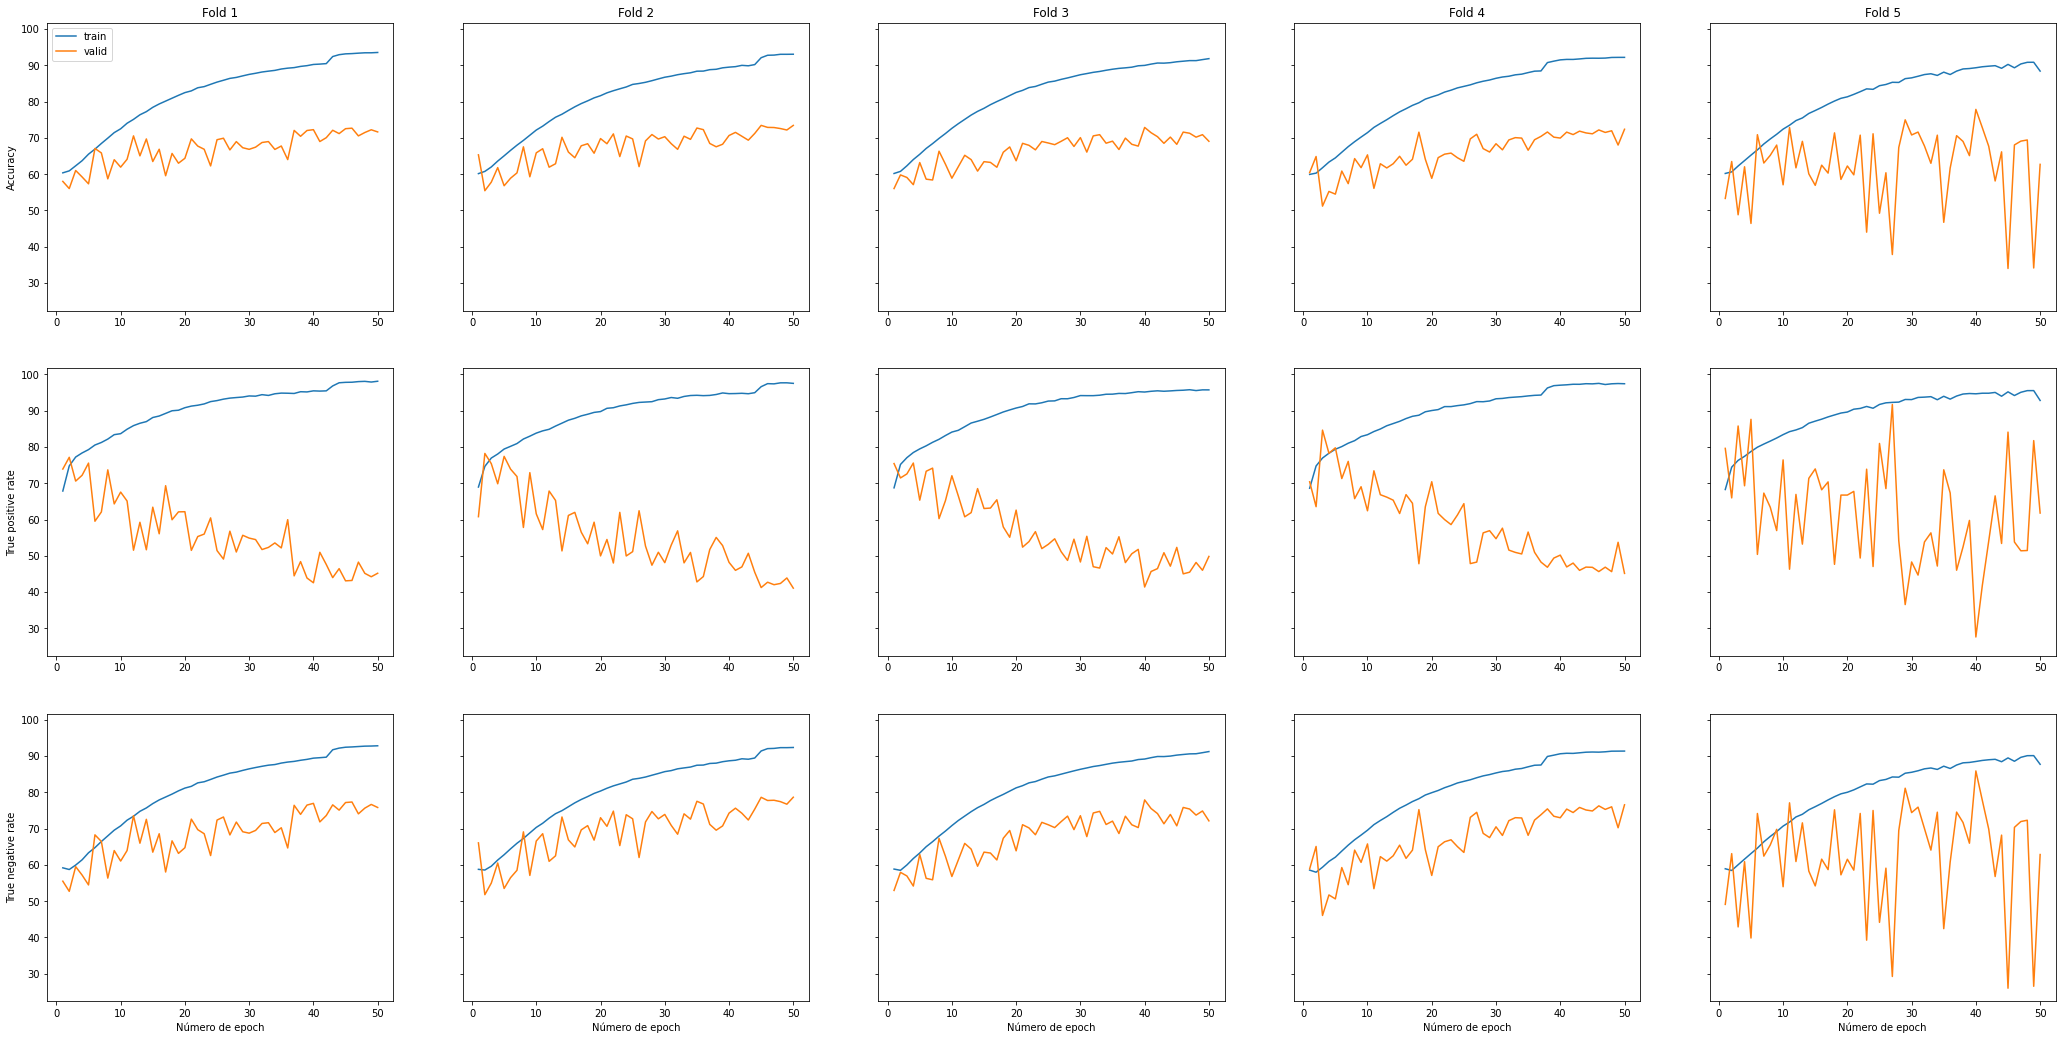

In [16]:
cross_val_data = pd.read_csv("training_info_nuevo_enfoque_sin_fixation_rank.csv")
fig, ax = plt.subplots(3, 5, figsize = (36,18),sharey=True)
ax[0][0].set_ylabel("Accuracy")
ax[1][0].set_ylabel("True positive rate")
ax[2][0].set_ylabel("True negative rate")
for i in range(1,6):
    fold_data = cross_val_data[cross_val_data['n_fold']==i]
    training_data = fold_data[fold_data['train']==1.0]
    valid_data = fold_data[fold_data['valid']==1.0]
    ax[0][i-1].set_title(f"Fold {i}")

    ax[2][i-1].set_xlabel("Número de epoch")
    ax[0][i-1].plot(training_data['n_epoch'], training_data['acc'])
    ax[1][i-1].plot(training_data['n_epoch'],training_data['tpr'])
    ax[2][i-1].plot(training_data['n_epoch'],training_data['tnr'])
    ax[0][i-1].plot(valid_data['n_epoch'],valid_data['acc'])
    ax[1][i-1].plot(valid_data['n_epoch'],valid_data['tpr'])
    ax[2][i-1].plot(valid_data['n_epoch'],valid_data['tnr'])


ax[0][0].legend(["train","valid"])
    

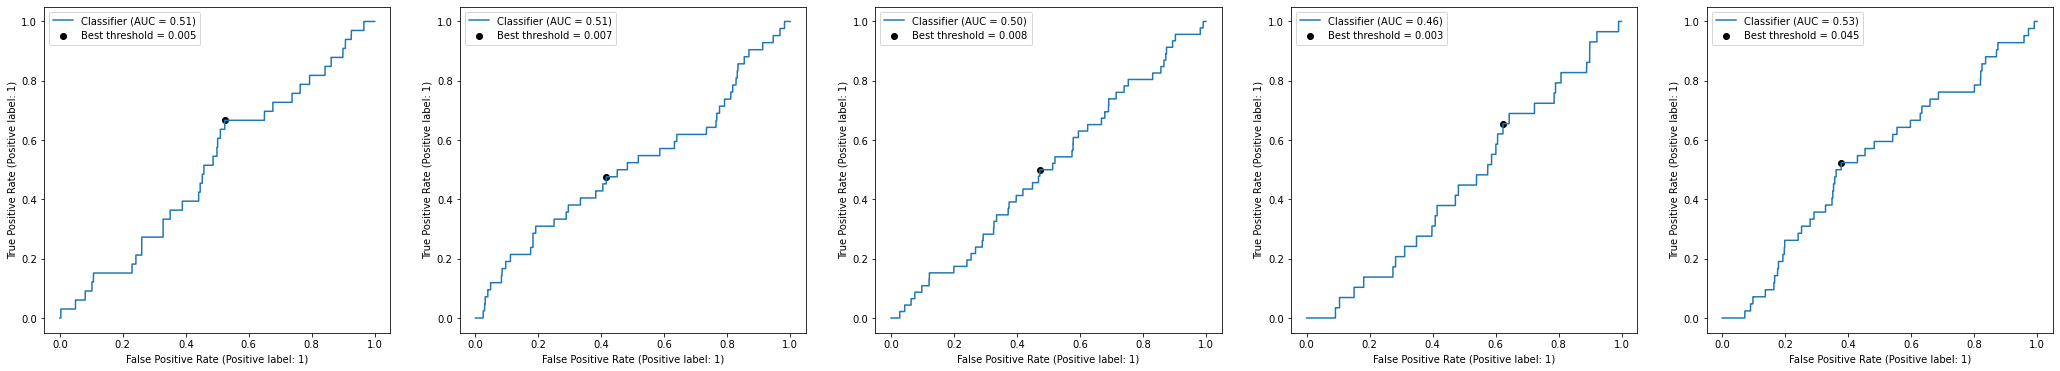

In [17]:

fig, ax = plt.subplots(1, 5, figsize = (36,6))
for i in range(1,6):
    dict = np.load(path.abspath(f"gng-outputs-{i}.npz"))
    outputs = dict["outputs"][1:]
    labels = np.array(dict["labels"][1:],dtype=np.intc)
    fixations = dict["fixations"][1:]

    fixation_indexes = np.where((fixations ==1) )[0] 
    labels = labels[fixation_indexes]
    outputs = outputs[fixation_indexes]
    RocCurveDisplay.from_predictions(labels, outputs,ax=ax[i-1])
    fpr, tpr, thresholds = roc_curve(labels, outputs)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    ax[i-1].scatter(fpr[ix], tpr[ix], marker='o', color='black', label=f'Best threshold = %.3f' % (thresholds[ix]))
    ax[i-1].legend()

